In [131]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import seaborn  as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.manifold import TSNE
import scipy.stats as stats

sns.set()


In [132]:
asm_file = pd.read_csv('asmoutputfile.csv')
byte_file = pd.read_csv('byteoutputfile.csv')

#removing ".txt" forom ids of byte file
byte_file['ID'] = byte_file['ID'].apply(lambda x : x[:-4])

labels = pd.read_csv('trainLabels.csv').rename(columns = {'Id' : "ID"})

257 Unigram byte features
51 Unigram asm features


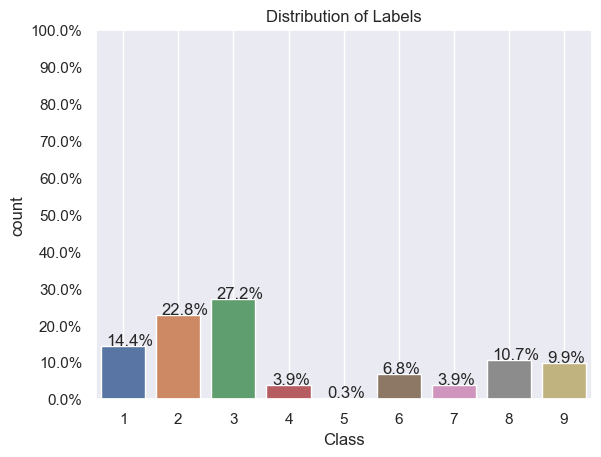

In [133]:
byte_cols = byte_file.columns.to_list()
asm_cols = asm_file.columns.to_list()

print(len(byte_cols) - 1 , 'Unigram byte features')
print(len(asm_cols) - 1 ,  'Unigram asm features')

def make_box_labels(Y):
    total = len(Y)*1.
    ax=sns.countplot(x="Class", data=Y)

    ax.set_title("Distribution of Labels")
    #ax.set_grid()
    for p in ax.patches:
            ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

    ax.yaxis.set_ticks(np.linspace(0, total, 11))

    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))

    plt.grid()
    plt.show()


final_df = byte_file.merge(asm_file , on = "ID" , how = "inner")
final_df = final_df.merge(labels , on = 'ID' , how = 'inner')
make_box_labels(final_df[["ID" , 'Class']])

In [134]:
class Analysis:

    def __init__(self):
        pass
    

    @staticmethod
    def normalize(df , columns):
        result1 = df.copy()
        for feature_name in columns:
            if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
                max_value = df[feature_name].max()
                min_value = df[feature_name].min()
                result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result1
    

    @staticmethod
    def get_Tsne_plot(result , val , data_y , type_):


        xtsne=TSNE(perplexity=val)
        result = xtsne.fit_transform(result.drop(['ID'], axis=1))
        vis_x = result[:, 0]
        vis_y = result[:, 1]

        plt.title("T-SNE Dist plot for " + type_)
        plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
        plt.colorbar(ticks=range(10))
        plt.clim(0.5, 9)
        plt.show()

    @staticmethod
    def get_counts(df):

        df_bytes = df.select_dtypes(include='int64').sum(axis = 0)
        df_bytes['Class'] = df['Class'].max()

        return df_bytes

    @staticmethod
    def get_probs(final_df , asm_cols , byte_cols):
        
        if "ID" in asm_cols:
            asm_cols.remove('ID')
        if "ID" in byte_cols:
            byte_cols.remove('ID')

        counts_df = final_df.groupby('Class').apply(Analysis.get_counts)

        byte_counts = counts_df[byte_cols[:]].sum(axis = 1)
        asm_counts = counts_df[asm_cols[:]].sum(axis = 1)

        bytes_probs = counts_df[byte_cols[:]].div(byte_counts.values , axis = 0).T
        asm_probs = counts_df[asm_cols[:]].div(asm_counts.values , axis = 0).T

        return bytes_probs , asm_probs

    @staticmethod
    def compare_dists(df):
        distributions = ['norm','bernoulli']


        fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(10, 30))

        for i, column in enumerate(df.columns):
            for j, distribution in enumerate(distributions):
                ax = axes[i][j]
                if distribution == 'norm':
                    stats.probplot(df[column], dist=distribution, plot=ax)
                    ax.set_title(f'{column} - {distribution.capitalize()}')
                elif distribution == 'bernoulli':
                    # For Bernoulli, generate quantiles for the empirical distribution
                    quantiles = df[column].rank(pct=True)
                    stats.probplot(quantiles, dist='uniform', plot=ax)
                    ax.set_title(f'{column} - Empirical vs Uniform')
                
                ax.grid(True)

        plt.tight_layout()
        plt.show()



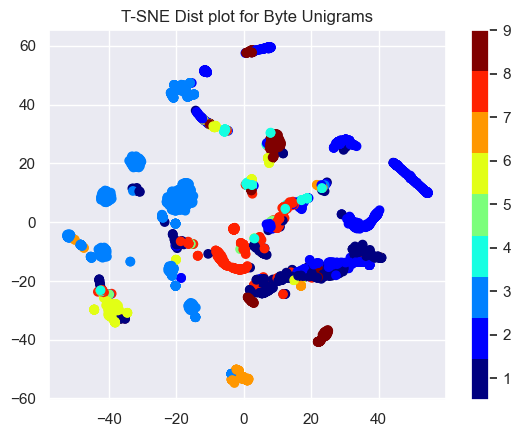

In [135]:
data_y = final_df.Class
byte_data = Analysis.normalize(final_df , byte_cols)
Analysis.get_Tsne_plot(byte_data , 50 , data_y , "Byte Unigrams")

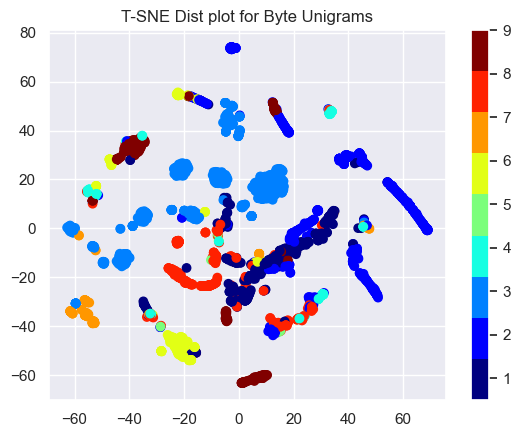

In [136]:
Analysis.get_Tsne_plot(byte_data , 30 , data_y , "Byte Unigrams")

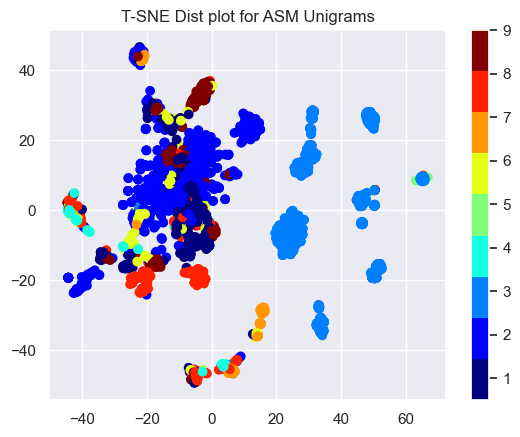

In [137]:
data_y = final_df.Class
asm_data = Analysis.normalize(final_df , asm_cols)
Analysis.get_Tsne_plot(asm_data.fillna(0) , 50 , data_y , "ASM Unigrams")

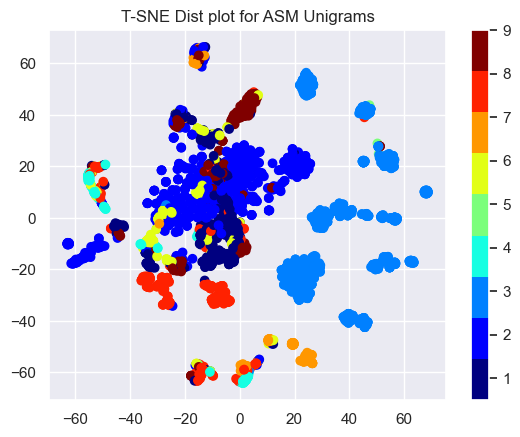

In [138]:
data_y = final_df.Class
asm_data = Analysis.normalize(final_df , asm_cols)
Analysis.get_Tsne_plot(asm_data.fillna(0) , 30 , data_y , "ASM Unigrams")

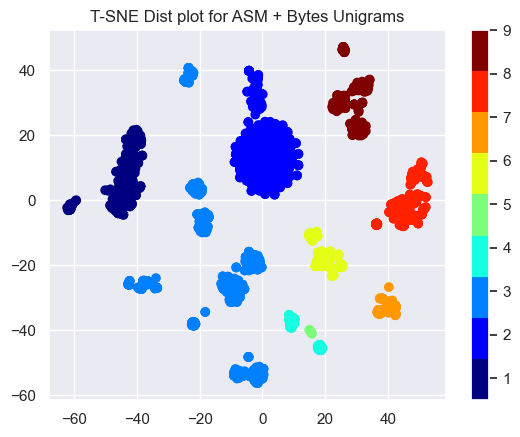

In [147]:
data_y = final_df.Class
whole_data = Analysis.normalize(final_df , asm_cols + byte_cols)
Analysis.get_Tsne_plot(whole_data.fillna(0) , 50 , data_y , "ASM + Bytes Unigrams")

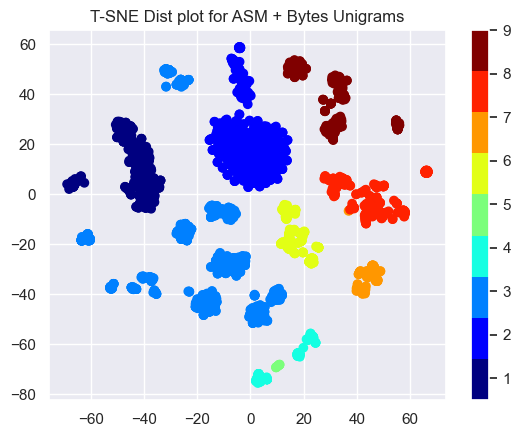

In [148]:
data_y = final_df.Class
whole_data = Analysis.normalize(final_df , asm_cols + byte_cols)
Analysis.get_Tsne_plot(whole_data.fillna(0) , 30 , data_y , "ASM + Bytes Unigrams")

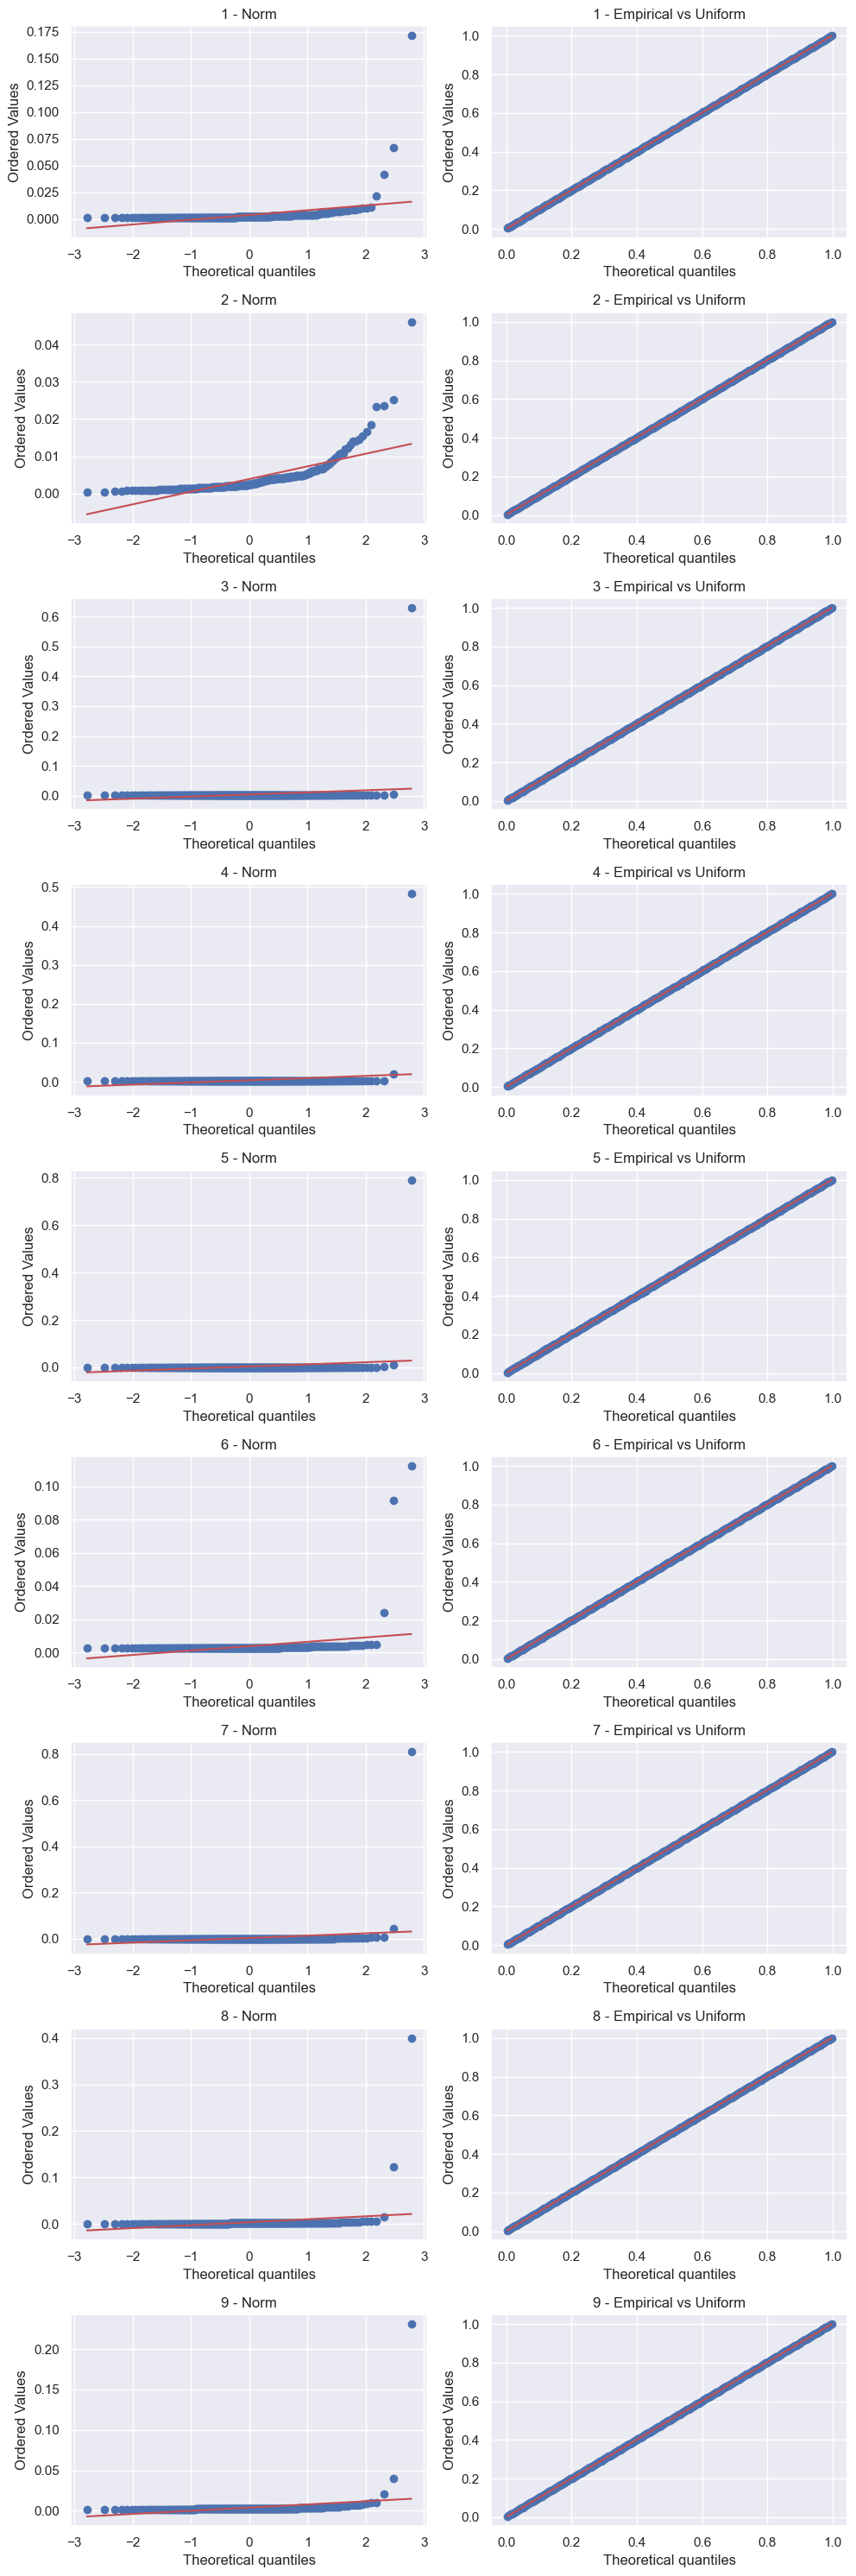

In [139]:
bytes_probs , _ = Analysis.get_probs(final_df , asm_cols , byte_cols)

Analysis.compare_dists(bytes_probs)

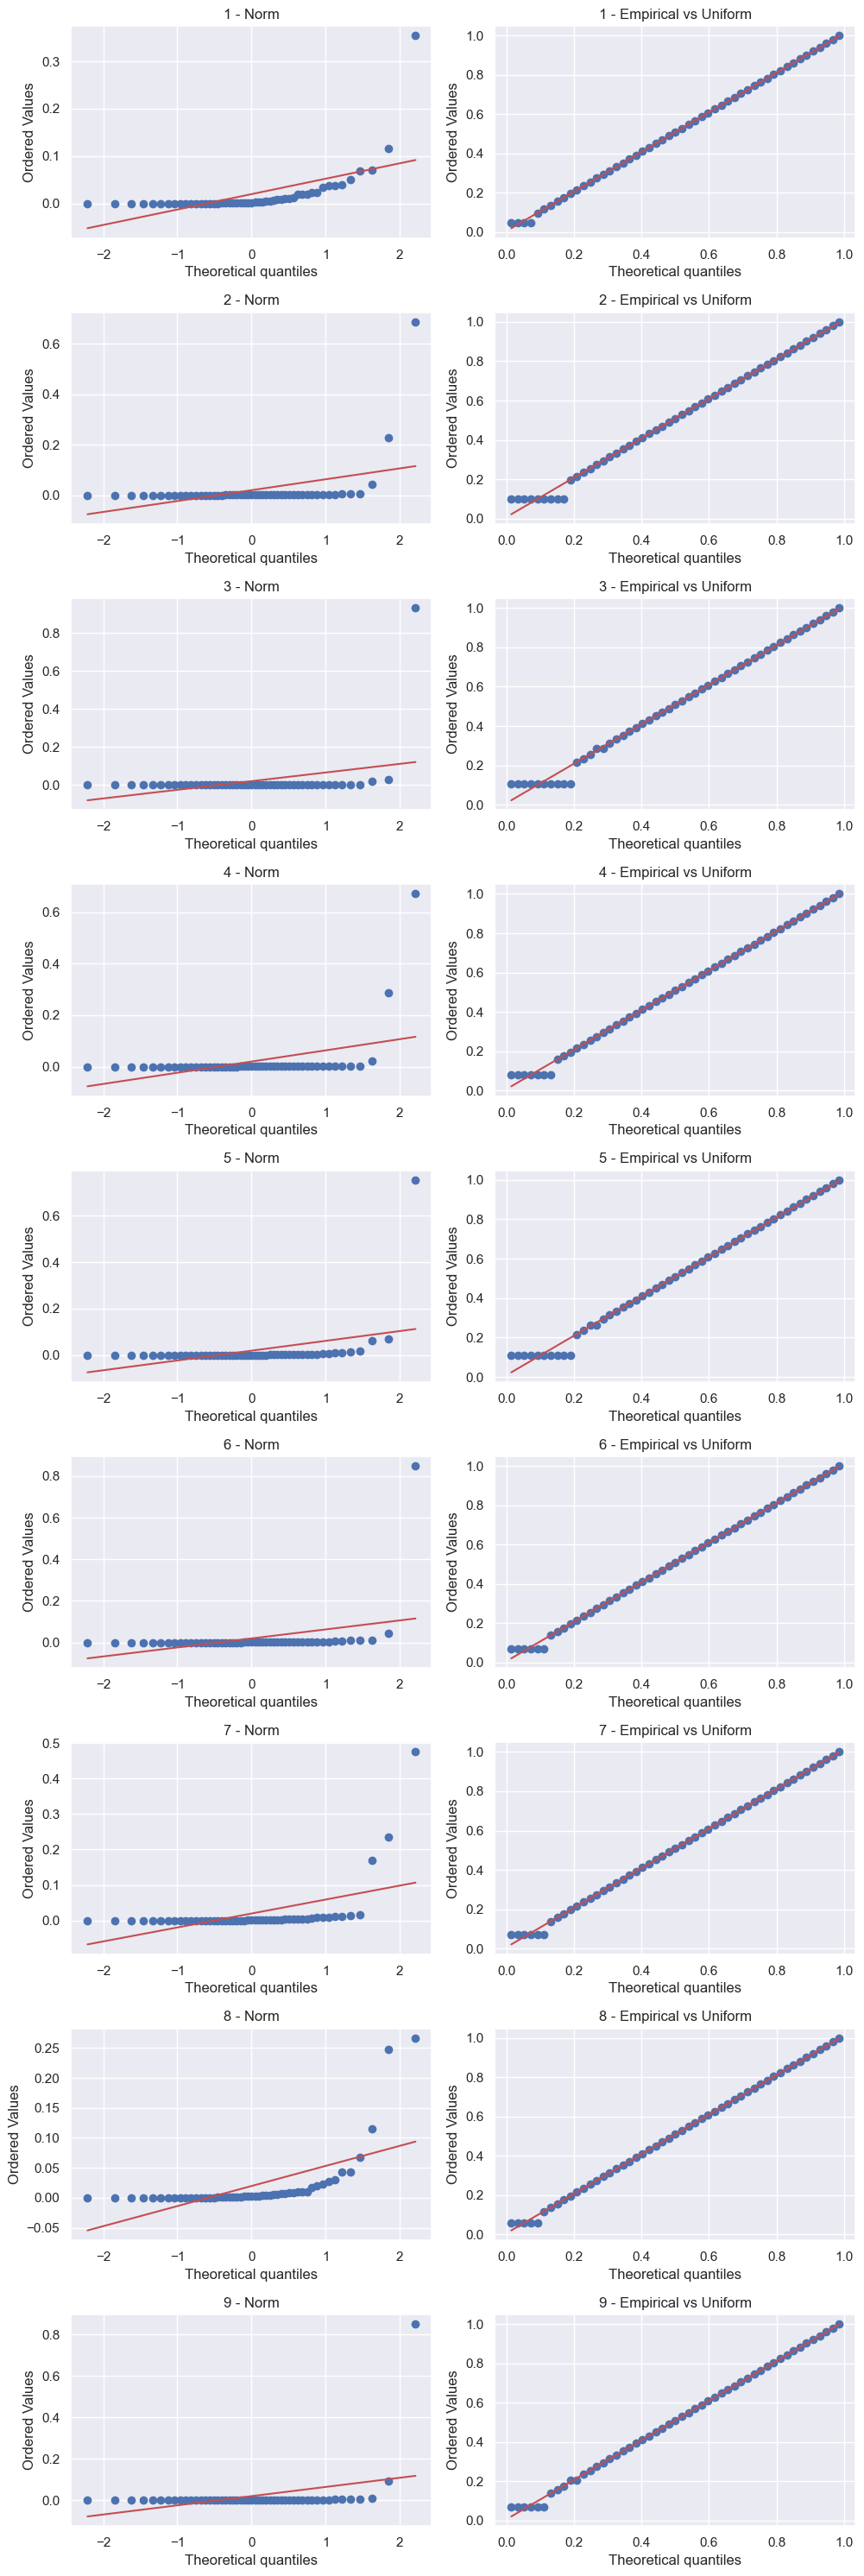

In [140]:
 _ , asm_probs = Analysis.get_probs(final_df , asm_cols , byte_cols)

 Analysis.compare_dists(asm_probs)

In [141]:
final_df.to_csv('final_df.csv' , header = True)